In [187]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
from tiny_ta import atr, rsi, sma

# End of the Month - Strategie im NASDAQ 100

Zunächst werden die Kursdaten für den NASDAQ 100 geladen und bereinigt

In [188]:
SYMBOL = "^NDX"
SYMBOL = "QQQ"

stock = yf.download(SYMBOL)

stock = stock[~(stock.High == stock.Low) & ~(stock.Open == stock.Close)]
stock = stock.dropna()

[*********************100%%**********************]  1 of 1 completed


Der VIX für die Volatilität wird als externer Indikator mit betrachtet

In [189]:
vix = yf.download("^VIX")
vix["vix"] = vix["Close"]
stock = pd.merge(
    stock,
    vix[
        [
            "vix",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Die 5 jährigen Staatsanleihen werden ebenfalls mit betrachtet

In [190]:
yield_5_years = yf.download("^FVX")

yield_5_years["yield_5yr"] = yield_5_years["Close"]
stock = pd.merge(
    stock,
    yield_5_years[
        [
            "yield_5yr",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Ein paar Indikatoren für spätere Auswertungen

In [191]:
stock["rsi_3"] = rsi(stock.Close, 3)
stock["rsi_7"] = rsi(stock.Close, 7)
stock["rsi_10"] = rsi(stock.Close, 10)

stock["atr_10"] = atr(stock, 10, smoothing="rma") / stock.Close * 100

adx_intervall = 21
adx = ta.adx(stock.High, stock.Low, stock.Close, adx_intervall)
stock["adx"] = adx[f"ADX_{adx_intervall}"]
stock["adx_direction"] = np.where(
    adx[f"DMP_{adx_intervall}"] > adx[f"DMN_{adx_intervall}"], 1, -1
)

stock["adx_10"] = ta.adx(stock.High, stock.Low, stock.Close, 10, 10)["ADX_10"]


stock["sma"] = sma(stock.Close, 20)
stock["sma_20"] = stock.Close / sma(stock.Close, 20)
stock["sma_50"] = stock.Close / sma(stock.Close, 50)
stock["sma_100"] = stock.Close / sma(stock.Close, 100)
stock["sma_200"] = stock.Close / sma(stock.Close, 200)

stock["sma_pct"] = (stock.Close / stock.sma).round(2)

stock["month"] = stock.index.month

Markiere die letzten x Tage und ersten x Tage im Monat für die geplanten Trades. 

In [192]:
days = 5

# Identify end of month
end_of_month = stock.groupby([stock.index.year, stock.index.month]).tail(days)

# Identify beginning of month
beginning_of_month = stock.groupby([stock.index.year, stock.index.month]).head(days)

# add countdown
end_of_month["countdown"] = -1
end_of_month["days"] = end_of_month["countdown"].cumsum().add(1).mod(days)
end_of_month.loc[end_of_month.days == 0, "days"] = days
end_of_month["days"] = end_of_month["days"] * -1

beginning_of_month["countdown"] = 1
beginning_of_month["days"] = beginning_of_month["countdown"].cumsum().mod(days)
beginning_of_month.loc[beginning_of_month.days == 0, "days"] = days

# Combine the results
marked_days = pd.concat([end_of_month, beginning_of_month])
marked_days["hold"] = 1

df = pd.merge(
    left=stock,
    right=marked_days[["hold", "days"]],
    left_index=True,
    right_index=True,
    how="left",
)

df.hold = df.hold.fillna(0)

df["buy"] = np.where(
    (df.hold.shift(1) == 0) & (df.hold == 1),
    1,
    np.where((df.hold == 1) & (df.hold.shift(-1) == 0), -1, np.nan),
)

df.hold = np.where(df.hold == 1, df.Low, np.nan)

## Jetzt zur Strategie
Es wird 5 Tage vor Monatsende gekauft und 5 Tage nach Monatsanfang gekauft

In [193]:
from backtesting import Strategy


class end_of_month(Strategy):
    """
    strategy for trend_trading
    """

    days_before = -5
    days_after = 5

    def ohlc(self, pos=-1) -> tuple:
        """
        helper function for ohlc data
        """
        return (
            self.data.Open[pos],
            self.data.High[pos],
            self.data.Low[pos],
            self.data.Close[pos],
        )

    def init(self):
        super().init()

        self.sma = self.I(lambda: self.data.sma, name="SMA")

        # self.rsi = self.I(lambda: self.data.rsi, name="RSI", overlay=False)
        self.atr_10 = self.I(lambda: self.data.atr_10, name="ATR", overlay=False)

        self.vix = self.I(lambda: self.data.vix, name="VIX", overlay=False)
        self.yield_5yr = self.I(
            lambda: self.data.yield_5yr, name="Yield 5", overlay=False
        )

    def next(self):
        # super().next()

        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if self.data.days[-1] == self.days_before:
            self.buy()

In [194]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":], end_of_month, cash=100_000, commission=0.002, trade_on_close=True
)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   48.013029
Equity Final [$]                284214.017173
Equity Peak [$]                 294184.075225
Return [%]                         184.214017
Buy & Hold Return [%]              657.644982
Return (Ann.) [%]                    8.952538
Volatility (Ann.) [%]               14.789905
Sharpe Ratio                         0.605314
Sortino Ratio                        0.973753
Calmar Ratio                         0.429178
Max. Drawdown [%]                  -20.859709
Avg. Drawdown [%]                   -2.795179
Max. Drawdown Duration     1184 days 00:00:00
Avg. Drawdown Duration       51 days 00:00:00
# Trades                                  148
Win Rate [%]                        58.783784
Best Trade [%]                      10.941882
Worst Trade [%]                     -7.804955
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

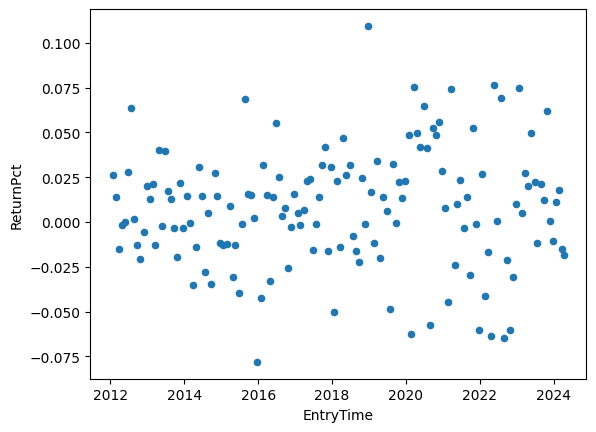

In [195]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

In [196]:
trades[trades.ReturnPct < -0.05]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
47,1075,986,995,112.815176,104.010002,-9465.562259,-0.078050,2015-12-24,2016-01-08,15 days
72,809,1508,1517,168.686706,160.210007,-6857.649816,-0.050251,2018-01-25,2018-02-07,13 days
97,803,2027,2036,221.832779,208.020004,-11091.658418,-0.062267,2020-02-24,2020-03-06,11 days
103,760,2154,2163,286.431705,269.950012,-12526.086768,-0.057541,2020-08-25,2020-09-08,14 days
119,655,2491,2500,404.286971,379.859985,-15999.675605,-0.060420,2021-12-27,2022-01-07,11 days
123,729,2573,2582,330.239147,309.250000,-15301.087832,-0.063557,2022-04-25,2022-05-06,11 days
127,809,2658,2667,321.221147,300.519989,-16747.236443,-0.064445,2022-08-25,2022-09-08,14 days
129,836,2700,2709,284.778411,267.589996,-14369.515024,-0.060357,2022-10-25,2022-11-07,13 days


Vielleicht wäre ein Stopp doch hilfreich

In [197]:
class end_of_month_with_SL(end_of_month):
    """
    strategy for trend_trading
    """

    skip_month = []

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if trade.pl_pct < -0.05:
                    trade.close()

                if self.data.days[-1] == self.days_after:
                    trade.close()

        if (
            self.data.days[-1] == self.days_before
            and self.data.month[-1] not in self.skip_month
        ):
            self.buy()

In [198]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":],
    end_of_month_with_SL,
    cash=100_000,
    commission=0.002,
    trade_on_close=True,
)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   46.840391
Equity Final [$]                256533.806001
Equity Peak [$]                 265534.137721
Return [%]                         156.533806
Buy & Hold Return [%]              657.644982
Return (Ann.) [%]                    8.039983
Volatility (Ann.) [%]               14.161055
Sharpe Ratio                         0.567753
Sortino Ratio                        0.901441
Calmar Ratio                         0.345937
Max. Drawdown [%]                  -23.241195
Avg. Drawdown [%]                   -2.955897
Max. Drawdown Duration     1155 days 00:00:00
Avg. Drawdown Duration       59 days 00:00:00
# Trades                                  148
Win Rate [%]                        58.108108
Best Trade [%]                      10.941882
Worst Trade [%]                     -7.299543
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

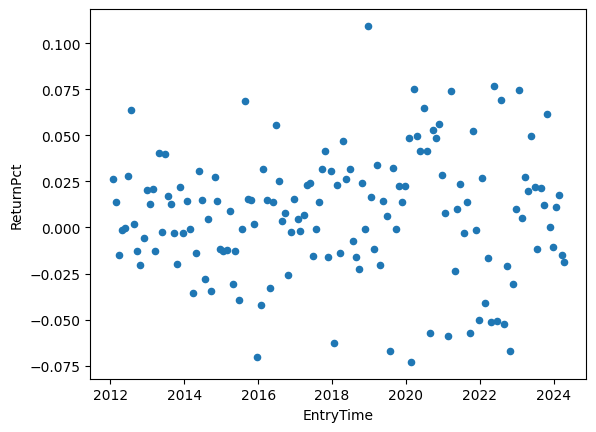

In [199]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

jetzt wird überprüft welche Tage für die Ein- und Ausstiege besser sein könnten.

In [200]:
stats, heatmap = bt.optimize(
    days_before=range(-5, 0, 1),
    days_after=range(1, 6),
    maximize="Profit Factor",  # "Equity Final [$]",
    max_tries=200,
    random_state=0,
    return_heatmap=True,
)

/Users/produktmanagement/Python/github/backtesting-trading-strategies/.venv/lib/python3.12/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [201]:
# heatmap
heatmap.sort_values().iloc[-3:]

days_before  days_after
-5           4             1.643891
             2             1.662736
             5             1.698658
Name: Profit Factor, dtype: float64

In [202]:
heatmap.groupby(["days_before", "days_after"]).mean().unstack()

days_after,1,2,3,4,5
days_before,,,,,
-5,1.616865,1.662736,1.510898,1.643891,1.698658
-4,1.599565,1.573967,1.491809,1.530184,1.607998
-3,1.459339,1.519721,1.374460,1.547403,1.619404
-2,1.128409,1.168292,1.160322,1.205277,1.306228
-1,1.082690,1.149773,1.106277,1.225685,1.329716


In [203]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   46.840391
Equity Final [$]                256533.806001
Equity Peak [$]                 265534.137721
Return [%]                         156.533806
Buy & Hold Return [%]              657.644982
Return (Ann.) [%]                    8.039983
Volatility (Ann.) [%]               14.161055
Sharpe Ratio                         0.567753
Sortino Ratio                        0.901441
Calmar Ratio                         0.345937
Max. Drawdown [%]                  -23.241195
Avg. Drawdown [%]                   -2.955897
Max. Drawdown Duration     1155 days 00:00:00
Avg. Drawdown Duration       59 days 00:00:00
# Trades                                  148
Win Rate [%]                        58.108108
Best Trade [%]                      10.941882
Worst Trade [%]                     -7.299543
Avg. Trade [%]                    

The Winner is ...

In [204]:
stats["_strategy"]

<Strategy end_of_month_with_SL(days_before=-5,days_after=5)>

In [205]:
# bt = Backtest(df["2012-01-01":], end_of_month, cash=100_000, commission=0.002)
stats = bt.run(days_before=-5, days_after=5)
bt.plot(superimpose=False, open_browser=False)

Row(id='35623', ...)

In [206]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   46.840391
Equity Final [$]                256533.806001
Equity Peak [$]                 265534.137721
Return [%]                         156.533806
Buy & Hold Return [%]              657.644982
Return (Ann.) [%]                    8.039983
Volatility (Ann.) [%]               14.161055
Sharpe Ratio                         0.567753
Sortino Ratio                        0.901441
Calmar Ratio                         0.345937
Max. Drawdown [%]                  -23.241195
Avg. Drawdown [%]                   -2.955897
Max. Drawdown Duration     1155 days 00:00:00
Avg. Drawdown Duration       59 days 00:00:00
# Trades                                  148
Win Rate [%]                        58.108108
Best Trade [%]                      10.941882
Worst Trade [%]                     -7.299543
Avg. Trade [%]                    

Die Win Rate beim Trading bezieht sich auf das Verhältnis der Anzahl der gewonnenen Trades zur Gesamtanzahl der Trades. 
Wenn jemand beispielsweise 70% seiner Trades gewinnt, beträgt seine Win Rate 70%.

In [207]:
stats["Win Rate [%]"]

58.108108108108105

Durchschnittlicher Gewinn in Prozent. 
Wie viel Gewinn oder Verlust wurden im Durchschnitt pro Trade erzielt.

In [208]:
stats["Avg. Trade [%]"]

0.6388346215241647

Der Profit-Faktor stellt die Verhältnisse zwischen Gewinnen und Verlusten dar.
Der Profit-Faktor wird berechnet, indem die Summe aller Profite (Gewinne) durch die Summe aller Verluste (einschließlich Gebühren und Kommissionen) für den gesamten Handelszeitraum geteilt wird.
Ein Profit-Faktor größer als 1 zeigt an, dass die Strategie profitabel ist. Je höher der Wert, desto besser.

Ein guter Profit-Faktor liegt normalerweise zwischen 1,75 und 41.
Ein Wert über 1,75 zeigt eine solide Strategie an, während Werte über 4 außergewöhnlich gut sind.

In [209]:
stats["Profit Factor"]

1.6986577862880257

In [210]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)

In [211]:
# merged.set_index('EntryTime')
monthly = pd.DataFrame(merged.groupby(merged.EntryTime.dt.month).ReturnPct.sum())
# global skip_month
skip_month = monthly[monthly["ReturnPct"] < 0.05].index.to_list()
print("Month to skip", skip_month)
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

Month to skip [2, 4, 8, 9]


,ReturnPct
ExitTime,
1,0.0916
2,0.0537
3,-0.0139
4,0.0627
5,0.0566
6,0.2218
7,0.2315
8,0.0461
9,0.0989


<Axes: title={'center': 'Gewinner Trades'}>

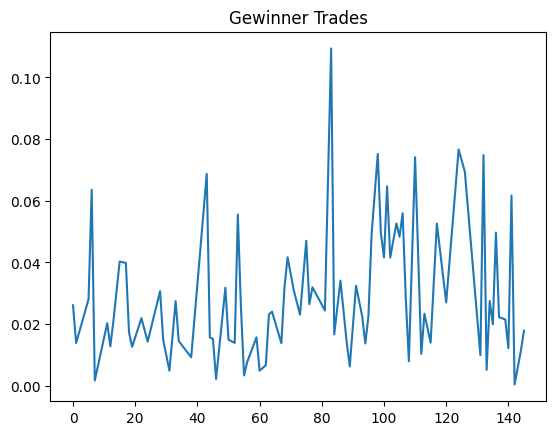

In [212]:
merged[merged.PnL > 0].ReturnPct.plot(title="Gewinner Trades")

<Axes: title={'center': 'Verlierer Trades'}>

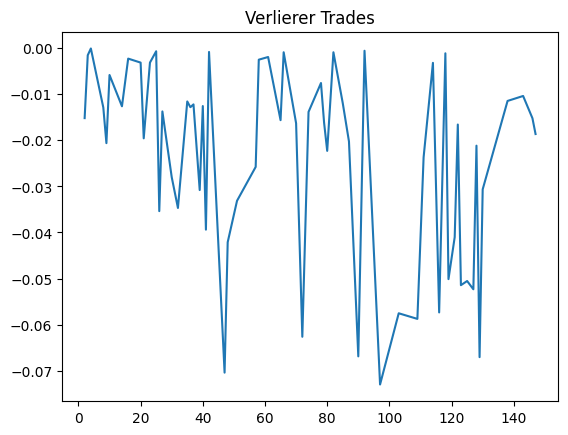

In [213]:
merged[merged.PnL < 0].ReturnPct.plot(title="Verlierer Trades")

In [214]:
class end_of_month_and_skip_month(end_of_month):
    """
    strategy for trend_trading
    """

    skip_month = []

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if (
            self.data.days[-1] == self.days_before
            and self.data.month[-1] not in self.skip_month
        ):
            self.buy()

In [215]:
df

,Open,High,Low,Close,Adj Close,Volume,vix,yield_5yr,rsi_3,rsi_7,...,sma,sma_20,sma_50,sma_100,sma_200,sma_pct,month,hold,days,buy
Date,,,,,,,,,,,,,,,,,,,,,
1999-03-10,51.125000,51.156250,50.281250,51.062500,43.547424,5232000,24.790001,5.112,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,50.281250,1.0,NaN
1999-03-11,51.437500,51.734375,50.312500,51.312500,43.760605,9688600,24.370001,5.126,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,50.312500,2.0,NaN
1999-03-12,51.125000,51.156250,49.656250,50.062500,42.694595,8743600,24.840000,5.061,12.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,49.656250,3.0,NaN
1999-03-15,50.437500,51.562500,49.906250,51.500000,43.920502,6369000,25.240000,5.046,65.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,49.906250,4.0,NaN
1999-03-16,51.718750,52.156250,51.156250,51.937500,44.293629,4905800,25.150000,5.017,73.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,51.156250,5.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-10,437.000000,439.239990,436.279999,438.369995,438.369995,61502200,15.800000,4.615,34.0,42.0,...,441.37,0.993203,1.003273,1.044484,1.112953,0.99,4,436.279999,-5.0,1.0
2024-04-11,440.260010,446.329987,437.959991,445.369995,445.369995,45474600,14.910000,4.623,71.0,59.0,...,441.63,1.008469,1.018361,1.059648,1.129463,1.01,4,437.959991,-4.0,NaN
2024-04-12,441.100006,442.239990,436.880005,438.269989,438.269989,53602600,17.309999,4.533,38.0,44.0,...,441.59,0.992482,1.001142,1.041467,1.110416,0.99,4,436.880005,-3.0,NaN


In [216]:
bt = Backtest(
    df["2012-01-01":],
    end_of_month_and_skip_month,
    cash=100_000,
    commission=0.002,
    trade_on_close=True,
)
stats = bt.run(days_before=-5, days_after=5, skip_month=skip_month)
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='37170', ...)

In [217]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   31.921824
Equity Final [$]                308160.288015
Equity Peak [$]                 314453.616793
Return [%]                         208.160288
Buy & Hold Return [%]              657.644982
Return (Ann.) [%]                    9.678394
Volatility (Ann.) [%]                11.78274
Sharpe Ratio                         0.821404
Sortino Ratio                        1.403771
Calmar Ratio                         0.571788
Max. Drawdown [%]                  -16.926535
Avg. Drawdown [%]                   -2.560054
Max. Drawdown Duration     1461 days 00:00:00
Avg. Drawdown Duration       62 days 00:00:00
# Trades                                   98
Win Rate [%]                        63.265306
Best Trade [%]                      10.941882
Worst Trade [%]                     -7.804955
Avg. Trade [%]                    

In [218]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)

In [219]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0737
2,0.1391
4,0.1328
6,0.2723
7,0.2320
8,0.1166
11,0.1674
12,0.0512


In [220]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.year).PnL.sum().round(1))

,PnL
ExitTime,
2012,7571.8
2013,8469.4
2014,3882.1
2015,-6060.0
2016,-5032.6
2017,6549.7
2018,4456.4
2019,20761.2
2020,66647.4


In [221]:
equity = stats["_equity_curve"]
equity.groupby(equity.index.year).Equity.last().round(1)

2012    107456.1
2013    116537.9
2014    118479.7
2015    112899.5
2016    107060.5
2017    113973.4
2018    128560.8
2019    140774.2
2020    209624.1
2021    246020.3
2022    247425.9
2023    312940.9
2024    308160.3
Name: Equity, dtype: float64